## TODO For Future Workshops
* Unsupervised Hybrid learning
  * pde loss from $A\zeta - b$
  * use library of system states, randomly sample from these to generate each batch. restart with new random state when integrating past $t_\text{max}$.
* Unsupervised learning
  * Use the discretized form of the PDE to optimize for both $v$ and $\zeta$
* extra tasks: change hyperparams, multiple random seeds
* open ended questions at end as discussion points
* further reading
* figure out how to compare multiple runs in tensorboard
* match colorlimits of error plots with colormaps
* add simulation parameters to hybrid net instead of relying on local variables

In [18]:
# Importing necessary libraries
%load_ext autoreload
import os

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from utils.sw_plotter import OverlayLinePlot, ContourPlot
from utils.sw_dataset import import_data


%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## SW Equations and Custom Dataset for SW Simulation Data

We are interested in solving the following form of Shallow Water Equations

$$\dfrac{\partial v}{\partial t} + \dfrac{c_D}{h}v|v|+g\dfrac{\partial \zeta}{\partial x} = 0$$

$$\dfrac{\partial \zeta}{\partial t} + \dfrac{\partial (vh)}{\partial x}=0$$

where $v(x, t)$ is the velocity, $ζ(x, t)$ is the positive or negative surface disturbance and $h(x, t) = \zeta(x, t) + h_0$ is the total depth. $c_D$ and $g$ correspond to drag coefficient and graviational acceleration respectively. The first equation describes Newton's second law ($F=ma$) acting on a fluid parcel, while the second models mass conservation.


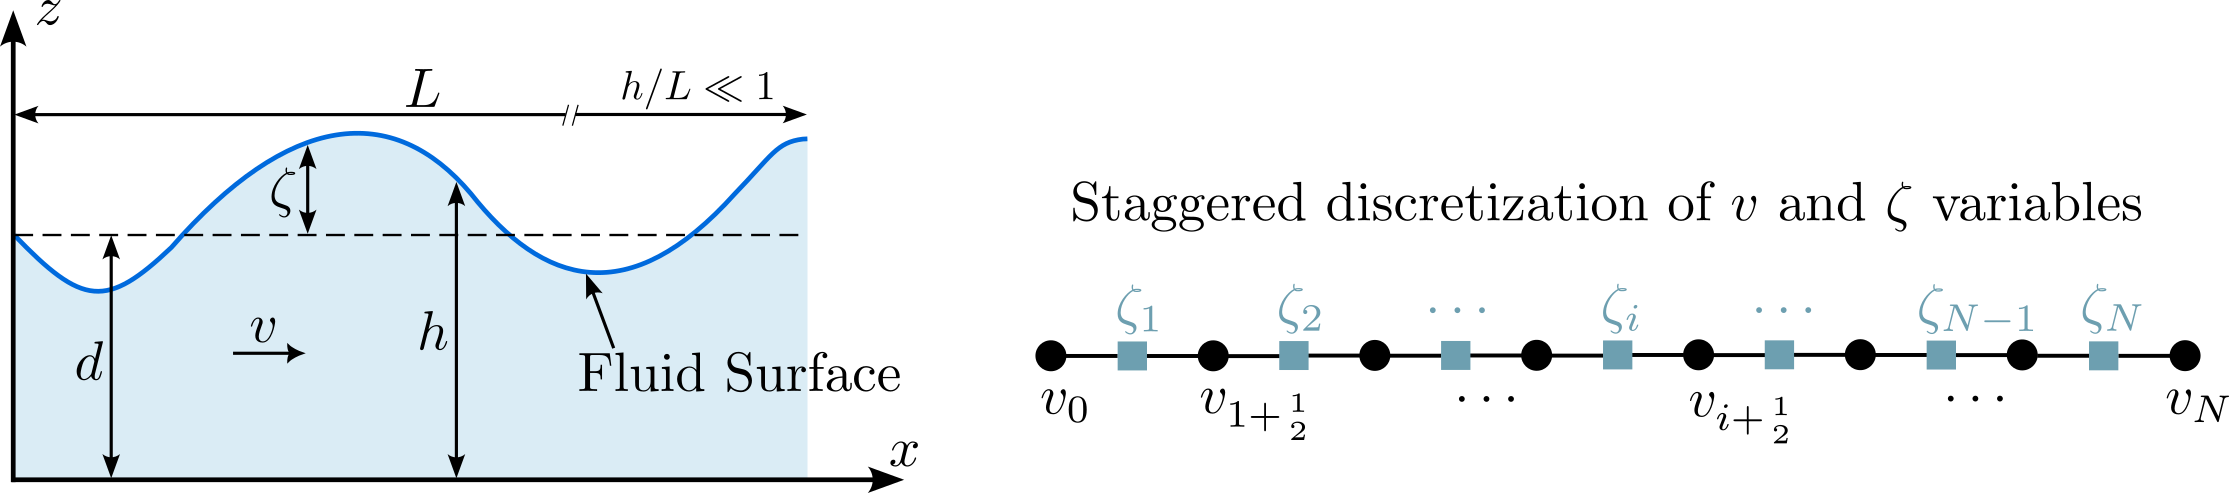



The figure on the left shows the variables defining the SWEs. On the right, we see the staggered grid used to discretize velocity and height. Note that we have one more velocity point than elevation/depth points.

### Boundary conditions
We work with closed "dry" boundaries, meaning no fluid flows in or out of the system and we have a Derichlet BC on $v$

$$
\forall t: v(0, t)= v(L, t) = 0
$$

### Initial conditions
Initial conditions for elevations are defined as "Gaussian bell"
$$
\zeta(x, 0) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-(x-\mu)^2 / \sigma^2}
\\
v(x, 0) = 0
$$
where the width and location of the bells are randomly distributed across simulations
$$
\mu \sim \mathbf U(-3L/4, 3L/4) \\
\sigma \sim \mathbf U(2.0, 8.0)
$$

## The problem we want to solve
### Time integration of PDEs
Given any **system state** at time $t$ for all locations $x$:
$$\forall x: \left(v(x, t), \zeta(x,t) \right)$$
we want to time-integrate the SWEs to obtain the system state at time $t+\Delta t$
$$\forall x:\left(v(x, t+\Delta t), \zeta(x, t+\Delta t) \right) = \left(
\int_t^{t+\Delta t} \frac{\partial v(x, t)}{\partial t},
\int_t^{t+\Delta t} \frac{\partial \zeta(x,t)}{\partial t}
\right) $$
we will consider the case where we deal with initial conditions and time-integrated outputs only on an evenly spaced grid with spacing $\Delta x$, and a fixed time step $\Delta t$.


### Classical PDE integration
Classical physics-based numerical methods compute these updates by calculating partial derivatives in space and time. Explicit methods do these calculations at time steps where $v,\zeta$ are already known, simplifying calculations but often requiring very small time steps to achieve accuracy and stability, often at high computational cost. (Semi)implicit methods can take larger time steps but most iteratively solve a system of equations at each time step until convergence, which can also be costly.

We'll discuss the discretization and time stepping used to solve this PDE in one of our later tasks. For now, it's enough to know that we've generated some simulation data from numerical simulation code, and we'll use that data to train neural networks and as a "ground truth" reference.

### Problem statement
In this tutorial, our goal is to **train a neural network to carry out time integration of SWEs** by $\Delta t$, such that the results match a semi-implicit scheme. By replacing the iterative solving operation of the numerical scheme with a forward pass through a neural network, we aim to produce a fast time-integration method whose computation time does not depend on the input data.

While we will not focus on computation times here due to using simplified, lightweight 1-D versions of the numerical model and deep learning architecture, this technique has demonstrated impressive speed increases compared to classical numerical solvers when applied to 2D and 3D fluid dynamics.

## Dealing with the Dataset

In this section, we'll import and use custom PyTorch class to load SWE simulation data from an HDF5 file. If you'd like to see how this class works later you can read through the code [here](https://github.com/alicanbekar/pi_lecture_pytorch/blob/main/sw_dataset.ipynb), but for now that isn't necessary. This dataset class is responsible for:
1. Reading data from an HDF5 file.
2. Normalizing the data, so that $\zeta$ and $v$ both range from roughly -1 to 1.
3. Splitting the data into training, validation, and testing datasets.
4. Retrieving sequences of SWE system state to create inputs and outputs for the trained models.

Run the next cell to install the necessary code and download the data.

In [5]:
try:
    import import_ipynb
except:
    !pip install -q import -ipynb

if not os.path.isfile("sw_dataset.ipynb"):
    !wget https: // raw.githubusercontent.com/alicanbekar/pi_lecture_pytorch/main/sw_dataset.ipynb
    !wget https: // raw.githubusercontent.com/alicanbekar/pi_lecture_pytorch/main/sw_plotter.ipynb
    !wget https: // raw.githubusercontent.com/alicanbekar/pi_lecture_pytorch/main/sw_dataset.ipynb
    !wget !wget https: // raw.githubusercontent.com/alicanbekar/pi_lecture_pytorch/main/data.npz



## Task 1: Explore the data
Run the following cells to retrieve and plot some data. We'll use the first simulation in the test set to evaluate our models visually.

In [6]:
datafile = 'data.npz'
train_data, val_data, test_data, stats = import_data(datafile, max_sims=50)
with np.load(datafile) as fid:
    nsteps = fid['zeta'].shape[1]

In [7]:
zeta_in, zeta_ref, v_in, v_ref = test_data[:nsteps]  # first simulation in test set
zeta_in, zeta_ref, v_in, v_ref = zeta_in.squeeze(1), zeta_ref.squeeze(1), v_in.squeeze(1), v_ref.squeeze(1)

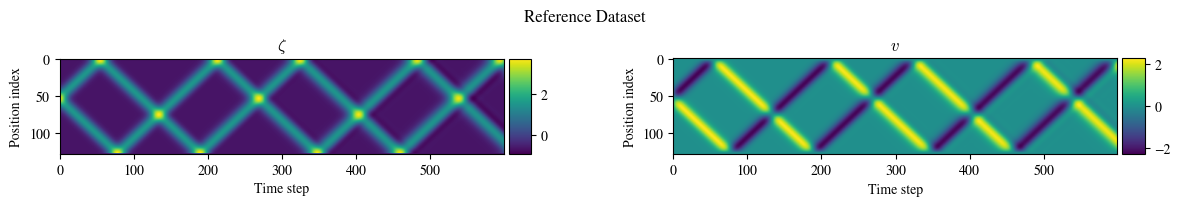

In [8]:
# Testing (Note: You should provide the zeta_ref and v_ref data yourself)
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.plot_data('Reference Dataset')

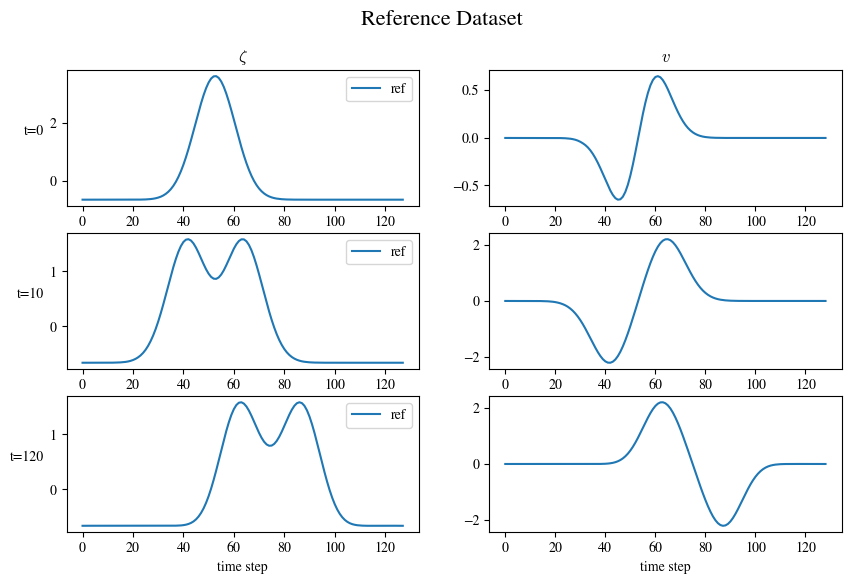

In [9]:
line_plotter = OverlayLinePlot(tsteps=[0, 10, 120])
line_plotter.add_data(zeta_data=zeta_ref, v_data=v_ref, label='ref')
line_plotter.plot_data('Reference Dataset')

## Task 2: Train a U-net for SWE time stepping

U-Net is a convolutional neural network architecture primarily used for biomedical image segmentation. In our case, we will adapt U-Net to handle 1D data from the SW simulations. The original paper for the UNet architecture is:
**Olaf Ronneberger, Philipp Fischer, & Thomas Brox. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation.**

The U-Net architecture is symmetric, and it consists of an encoding (downsampling) path, followed by a decoding (upsampling) path. Skip connections are used to pass the information from the encoding path to the decoding path, which helps the network retain spatial details.

![UNet](UNet.png)

Let's walk through the code and its structure:


In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # this code defines all necessary network layers. for the order in which they're used, see the forward() method below.

        # Initial convolution layers for two different input types
        self.conv_zeta = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.conv_vel = nn.Conv1d(2, 8, kernel_size=4, padding=1)  # second channel is for boundary mask

        # Encoder (downsampling) blocks
        self.enc1 = self.u_net_block(16, 16)
        self.enc2 = self.u_net_block(16, 32)
        self.enc3 = self.u_net_block(32, 64)
        self.enc4 = self.u_net_block(64, 128)
        self.enc5 = self.u_net_block(128, 256)

        # Pooling layer for downsampling
        self.pool = nn.MaxPool1d(
            2)  # this layer reduces each channel's pixel count by half, by taking the max of neighboring pixels

        # Upsampling layers
        self.up1 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)

        # Decoder (upsampling) blocks
        self.dec1 = self.u_net_block(256, 128)
        self.dec2 = self.u_net_block(128, 64)
        self.dec3 = self.u_net_block(64, 32)
        self.dec4 = self.u_net_block(32, 16)

        # Output convolution layers
        self.output_dec_zeta = nn.Conv1d(16, 1, kernel_size=3, padding=1)
        self.output_dec_vel = nn.Conv1d(16, 1, kernel_size=2, padding=1)

    def u_net_block(self, in_channels, out_channels):
        """
        Creates a U-Net block with two convolution layers followed by batch normalization and ReLU activation.
        """
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x_zeta, x_vel):
        # compute the boundary mask
        mask = torch.ones_like(x_vel).to(device)
        mask[..., 0] = 0.0
        mask[..., -1] = 0.0
        x_vel_mask = torch.cat([x_vel, mask], dim=1)  # add the mask as an extra channel on velocity points

        # Initial convolution operations
        x_zeta = self.conv_zeta(x_zeta)  # input and outputs on \zeta grid
        x_vel_mask = self.conv_vel(x_vel_mask)  # inputs (vel and boundary mask) on v grid, outputs on \zeta grid

        # Concatenate the two feature maps along the channel dimension
        x_combined = torch.cat([x_vel_mask, x_zeta], dim=1)

        # Encoding process
        e1 = self.enc1(x_combined)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        # Decoding process with skip connections
        d1 = self.up1(e5)
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.dec4(d4)

        # Separate output convolutions
        delta_zeta = self.output_dec_zeta(d4)
        delta_vel = self.output_dec_vel(d4)
        return delta_zeta, delta_vel

### Key points:

- **Input layers**: Recall that $\zeta$ and $v$ are defined at different numbers of spatial locations due to the staggered grid we've used for discretization. To obtain activations of the same size after the input layers, we use different filter sizes for the convolutions applied to $\zeta$ and $v$. The result is a unified set of channels with the same size as $\zeta$.

- **Boundary mask**: We will provide an extra channel of data on the $v$ points that is zero on the interior points, and one on the boundaries. This allows the network to modify its calculations near boundaries to account for reflecting waves etc.

- **u_net_block**: This function returns a sequence of layers that performs two sets of (convolution -> batch normalization -> ReLU activation). We chain these operations using `nn.Sequential`.

- **Encoder**: Remember, as you go deeper into the encoder, you are reducing the spatial dimensions (using max pooling) and typically increasing the number of channels.

- **Decoder**: It's the reverse of the encoder. For each block, you will upsample to increase spatial dimensions and typically decrease the number of channels. Make sure to include the skip connections from the encoder. This can be done using torch's concatenation.

- **Output Layers**: The goal is to transform the deep feature maps into our desired output. Depending on the task, this could be a segmentation mask, regression map, etc.

Remember, the architecture of U-Net is symmetric. It might be helpful to sketch the network or list down the sizes of feature maps as you code.




# Training the U-Net Model

After defining our U-Net architecture, it's time to set up a training loop. This loop will iteratively update our model's weights using our dataset. Let's break down the steps needed:

1. **Setting Up**: Import necessary libraries, define hyperparameters, initialize computational device, and set random seeds.
2. **Data Loading**: Load the training and validation datasets and create data loaders.
3. **Model & Training Essentials Initialization**: Create mask, model, optimizer, and loss function.
4. **Training Loop**: For each epoch, forward propagate the input through the model, compute the loss, backpropagate the errors, and update the model weights.
5. **Validation Loop**: After training for each epoch, we will evaluate the model's performance on the validation dataset.
6. **Logging & Visualization**: Log metrics such as losses to TensorBoard.
7. **Model Saving**: After all epochs are completed, save the model's state dict.

Let's get started with the skeleton and explanations:


In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import random

### Step A: Setting Up

First, we need to define some hyperparameters, which are constants that determine how the model will be trained. We also set a computational device (either a GPU or CPU) to ensure our tensors and model are loaded onto the right hardware.


In [12]:
# Define hyperparameters
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
NUMTIME = 600  # time steps per simulation
EXP_NAME = 'plain_time_integrator'

# Initialize TensorBoard writer for logging
log_dir = f'runs/exp_{EXP_NAME}'
writer = SummaryWriter(log_dir=log_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network_name_1 = 'Plain UNet'


def set_seeds(seed=42):
    # This function ensures reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

### Step B: Define data loaders

Next, load the training and validation datasets. We also create data loaders that will allow us to fetch batches of data.


In [13]:
dataloader_train = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dataloader_valid = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

### Step C: Initialize model, optimizer and loss

Before training, initialize the model, the optimizer responsible for weight updates, and the loss function.

In [14]:
set_seeds(seed=42)
model = UNet().to(device)  # instantiate the Unet we defined with random initial parameters
optimizer = optim.Adam(model.parameters(), lr=LR)  # this is basically a fancy version of gradient descent
criterion = torch.nn.MSELoss()  # we aim to minimize the mean square residual in normalized units

### Step D: Run the Training/Validation Loop

Running training loop involves:
1. Setting the model to training mode.
2. Iterating through batches of data from the dataloader, which randomly samples system states from our simulation dataset.
3. Making predictions for the next time step using the model.
4. Calculating the loss.
5. Backpropagating to compute gradients.
6. Updating model parameters using the optimizer.

A single training *epoch* refers to training on all data points once. After each training epoch, you'll also run a validation loop to check the model's performance on unseen data. We will develop this training loop as a class which can take our UNet model as input, so when we make modifications to the architecture, we can still use this trainer.


In [15]:
def update_function(model, input_zeta, input_vel):
    # this function predicts the next time step using the neural network
    delta_zeta, delta_vel = model(input_zeta, input_vel)
    output_zeta = input_zeta + delta_zeta
    output_vel = input_vel + delta_vel
    return output_zeta, output_vel

In [19]:
class UNetTrainer:
    def __init__(self, model, device, dataloader_train, dataloader_valid, optimizer, criterion, writer, update_function,
                 epochs):
        self.model = model
        self.device = device
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.writer = writer
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.update_function = update_function

    def train_epoch(self):
        train_losses = []
        self.model.train()

        for input_zeta, targets_zeta, input_vel, targets_vel in tqdm(self.dataloader_train, total=len(self.dataloader_train)):
            self.optimizer.zero_grad()
            input_zeta, input_vel = input_zeta.to(self.device), input_vel.to(self.device)
            targets_zeta, targets_vel = targets_zeta.to(self.device), targets_vel.to(self.device)
            output_zeta, output_vel = self.update_function(model, input_zeta, input_vel)
            loss_zeta = self.criterion(output_zeta, targets_zeta)
            loss_vel = self.criterion(output_vel, targets_vel)
            total_loss = (loss_zeta + loss_vel) / 2.0
            total_loss.backward()
            self.optimizer.step()
            train_losses.append(total_loss.item())

        return np.mean(train_losses)

    def validate_epoch(self):
        valid_losses = []
        self.model.eval()
        with torch.no_grad():
            for input_zeta, targets_zeta, input_vel, targets_vel in self.dataloader_valid:
                input_zeta, input_vel = input_zeta.to(self.device), input_vel.to(self.device)
                targets_zeta, targets_vel = targets_zeta.to(self.device), targets_vel.to(self.device)
                output_zeta, output_vel = self.update_function(model, input_zeta, input_vel)
                loss_zeta = self.criterion(output_zeta, targets_zeta)
                loss_vel = self.criterion(output_vel, targets_vel)
                combined_loss = (loss_zeta + loss_vel) / 2.0
                valid_losses.append(combined_loss.item())

        return np.mean(valid_losses)

    def train(self):
        for epoch in range(self.epochs):
            train_loss = self.train_epoch()
            self.writer.add_scalar("Loss/train", train_loss, epoch)

            valid_loss = self.validate_epoch()
            self.writer.add_scalar("Loss/valid", valid_loss, epoch)

            print(f"Epoch {epoch + 1}/{self.epochs} Train Loss: {train_loss:.8f} Valid Loss: {valid_loss:.8f}")

In [20]:
trainer = UNetTrainer(model, device, dataloader_train, dataloader_valid, optimizer, criterion, writer, update_function,
                      epochs=EPOCHS)
trainer.train()

  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.00012310 Valid Loss: 0.00011101


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.00010703 Valid Loss: 0.00011085


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.00009843 Valid Loss: 0.00006054


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.00008706 Valid Loss: 0.00007936


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.00007629 Valid Loss: 0.00005971


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.00006688 Valid Loss: 0.00010696


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.00006356 Valid Loss: 0.00004730


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.00006333 Valid Loss: 0.00007491


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.00006188 Valid Loss: 0.00007854


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.00006016 Valid Loss: 0.00006243


### Step E: Use logging & visualization tools

We've already added logging functionality in the training loop using TensorBoard's `SummaryWriter`. This will help visualize training and validation loss curves, among other metrics you might want to track.


In [21]:
%tensorboard --logdir $log_dir

Launching TensorBoard...

For the following tasks, you won't be specifically asked to use tensorboard, but it may help you diagnose problems and compare convergence rates and final validation losses of the various models you'll be training.

### Step F: save the model
Save the model's state dict, which contains the model's learned parameters. Later, you can load this state dict to make predictions with the trained model.


In [22]:
torch.save(model.state_dict(), EXP_NAME + '.pth')

### Step G: visualize results
Now, based on the visualization code above, compare our trained PDE time stepper's predictions for each time step to the reference numerical solution. For now, use the numerical solution at the previous time step as input, for one complete simulation in the test set.

In [23]:
model.eval();  # use frozen batch norm

In [24]:
# run the network on all data to predict the next time step
zeta_est, v_est = update_function(model, zeta_in.unsqueeze(1).to(device), v_in.unsqueeze(1).to(device))

In [25]:
# detach from the computation graph and remove unused (channel) dimension
# so we can call plotting functions
zeta_est, v_est = zeta_est.detach().squeeze(1), v_est.detach().squeeze(1)
zeta_est_plt = zeta_est.to('cpu')
v_est_plt = v_est.to('cpu')

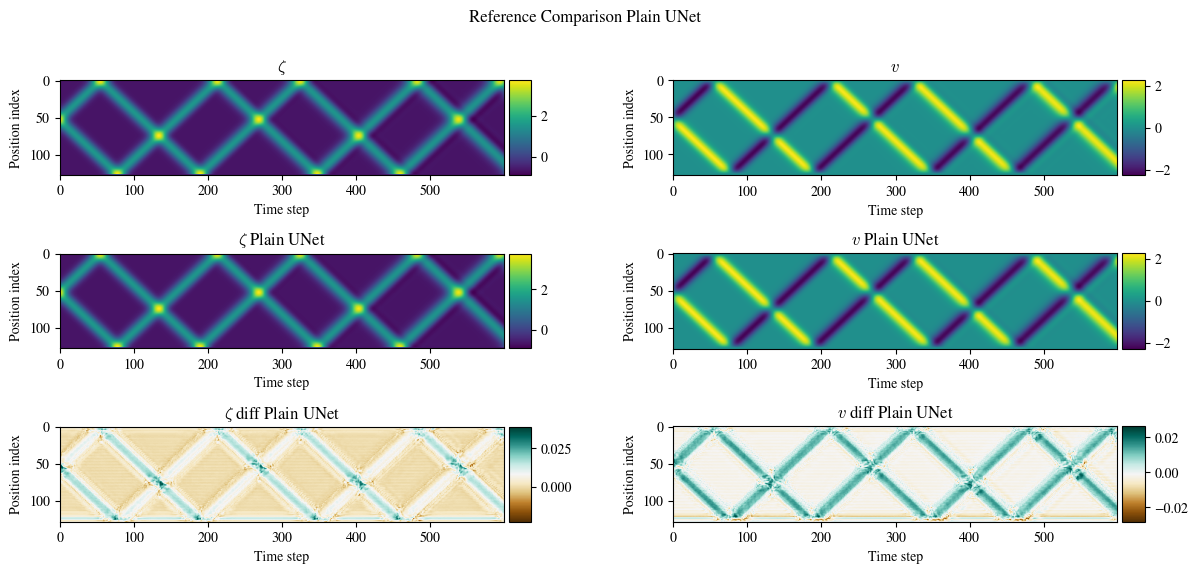

In [26]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_est_plt, v_est_plt], title=['$\zeta$ ' + network_name_1, '$v$ ' + network_name_1],
                         showxax=[True, True])
contour_plotter.add_data([zeta_est_plt - zeta_ref, v_est_plt - v_ref],
                         title=['$\zeta$ diff ' + network_name_1, '$v$ diff ' + network_name_1], cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison ' + network_name_1)

### Step H: test autoregressive prediction
Now try providing only an initial condition from a reference simulation, and then feed the trained time stepper's outputs back as inputs repeatedly. Compare the results of this "autoregressive mode" to the full numerical simulation, using the same type of graphs as before.

In [27]:
def arsolve(zeta_in, vel_in, model):
    zeta, v = zeta_in.unsqueeze(1)[0:1], vel_in.unsqueeze(1)[0:1]
    zeta_ar, v_ar = [], []
    for i in range(zeta_est.shape[0]):
        zeta, v = update_function(model, zeta, v)
        zeta, v = zeta.detach(), v.detach()
        zeta_ar.append(zeta)
        v_ar.append(v)

    zeta_ar = torch.cat(zeta_ar, axis=0).squeeze(1)
    v_ar = torch.cat(v_ar, axis=0).squeeze(1)
    return zeta_ar, v_ar

In [28]:
# initialize from IC of reference simulation
zeta_ar, v_ar = arsolve(zeta_in[0:1, ...].to(device), v_in[0:1, ...].to(device), model)
zeta_ar_plt = zeta_ar.to('cpu')
v_ar_plt = v_ar.to('cpu')

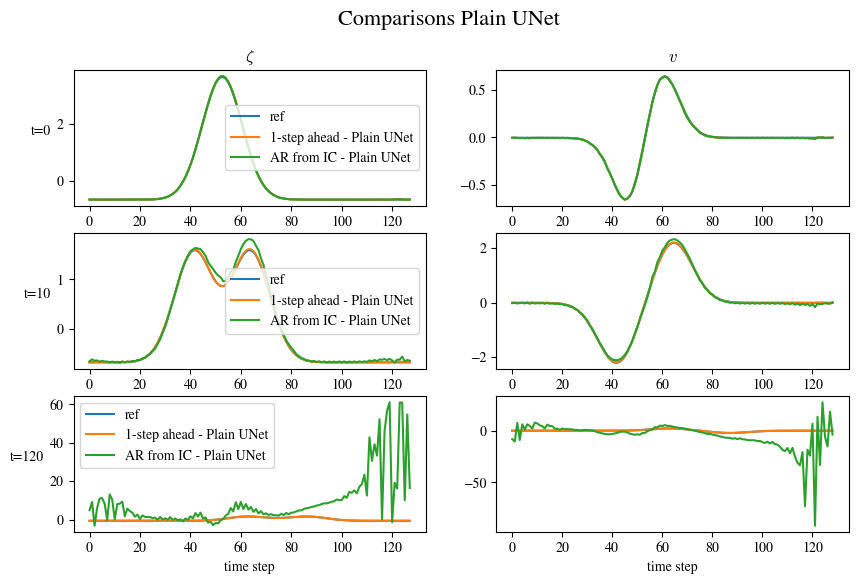

In [29]:
line_plotter = OverlayLinePlot(tsteps=[0, 10, 120])
line_plotter.add_data(zeta_data=zeta_ref, v_data=v_ref, label='ref')
line_plotter.add_data(zeta_data=zeta_est_plt, v_data=v_est_plt, label='1-step ahead - ' + network_name_1)
line_plotter.add_data(zeta_data=zeta_ar_plt, v_data=v_ar_plt, label='AR from IC - ' + network_name_1)
line_plotter.plot_data('Comparisons ' + network_name_1)

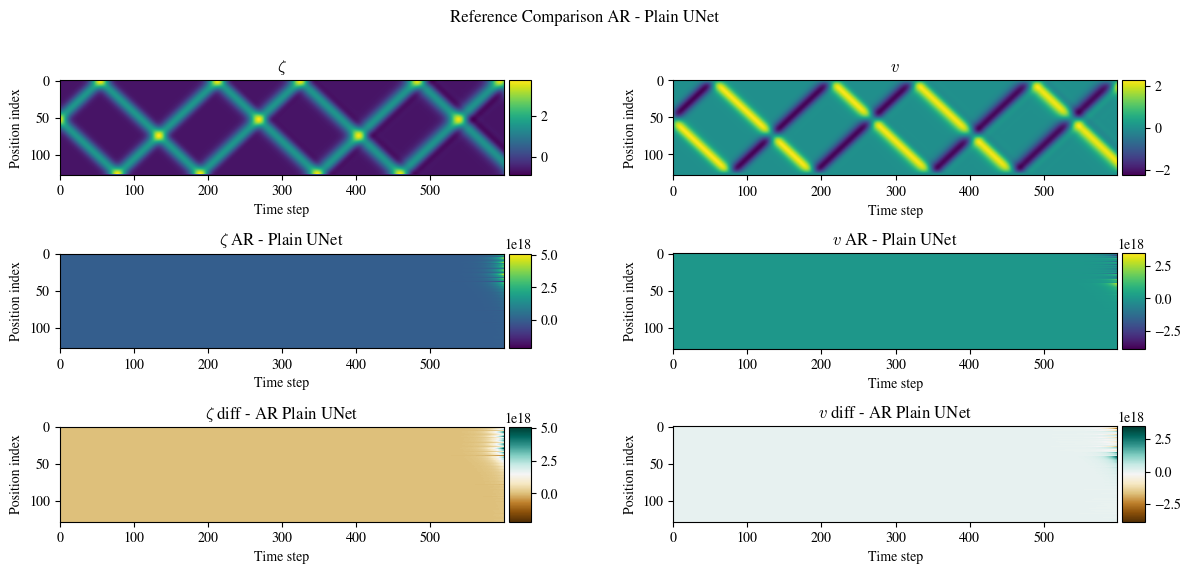

In [30]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_ar_plt, v_ar_plt],
                         title=['$\zeta$ AR - ' + network_name_1, '$v$ AR - ' + network_name_1], showxax=[True, True])
contour_plotter.add_data([zeta_ar_plt - zeta_ref, v_ar_plt - v_ref],
                         title=['$\zeta$ diff - AR ' + network_name_1, '$v$ diff - AR ' + network_name_1],
                         cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison AR - ' + network_name_1)

## Task 3: enforcing boundary constraints
Now we'll enforce the first physics-derived constraint on our network: we impose hard boundary conditions.

Below we define a wrapper class that calls the Unet, then simply overwrites the velocities on the boundary with the correct (zero) value. While almost trivial, this is our first step in imposing physical principles on our neural networks.

In [31]:
class HardBCModel(nn.Module):
    def __init__(self, model):
        super(HardBCModel, self).__init__()
        self.model = model

    def forward(self, zeta, v):
        zeta, v = self.model(zeta, v)  # advance one time step
        v[..., 0] = 0.0
        v[..., -1] = 0.0

        return zeta, v

Now do the folllowing:
* reseed the RNG
* initialize a new Unet
* Use the Unet to make a HardBCModel
* initialize a new UnetTrainer and optimizer
* Train the Network
* Compare results to the reference solution, and the previous approach

In [32]:
set_seeds(seed=42)
network_name_2 = 'HardBC UNet'
net = UNet().to(device)  # instantiate the Unet we defined with random initial parameters
model = HardBCModel(net)
optimizer = optim.Adam(model.parameters(), lr=LR)  # this is basically a fancy version of gradient descent

In [33]:
trainer = UNetTrainer(model, device, dataloader_train, dataloader_valid, optimizer, criterion, writer, update_function,
                      epochs=EPOCHS)
trainer.train()
torch.save(model.state_dict(), EXP_NAME + '_hardbcs.pth')

  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.00487284 Valid Loss: 0.00040338


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.00036496 Valid Loss: 0.00021908


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.00024602 Valid Loss: 0.00017313


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.00018208 Valid Loss: 0.00010902


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.00014788 Valid Loss: 0.00011105


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.00012928 Valid Loss: 0.00006716


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.00010876 Valid Loss: 0.00008035


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.00010114 Valid Loss: 0.00010429


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.00009789 Valid Loss: 0.00007315


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.00008241 Valid Loss: 0.00006098


In [34]:
model.eval();  # use frozen batch norm

In [35]:
# run the network on all data to predict the next time step
zeta_est_bc, v_est_bc = update_function(model, zeta_in.unsqueeze(1).to(device), v_in.unsqueeze(1).to(device))

In [36]:
# detach from the computation graph and remove unused (channel) dimension
# so we can call plotting functions
zeta_est_bc, v_est_bc = zeta_est_bc.detach().squeeze(1), v_est_bc.detach().squeeze(1)
zeta_est_bc_plt = zeta_est_bc.to('cpu')
v_est_bc_plt = v_est_bc.to('cpu')

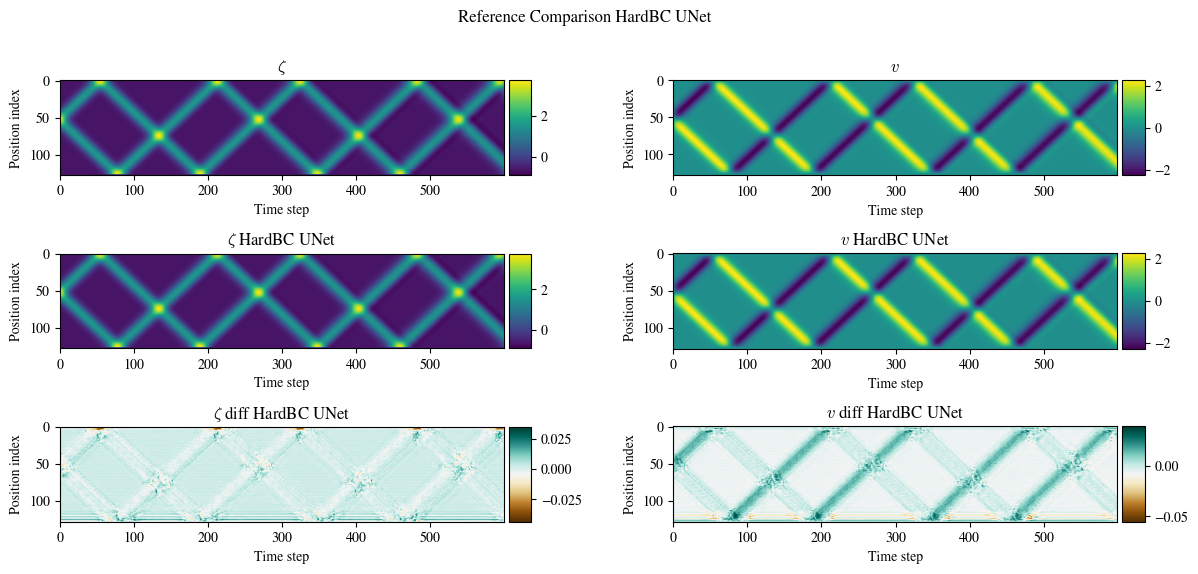

In [37]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_est_bc_plt, v_est_bc_plt], title=['$\zeta$ ' + network_name_2, '$v$ ' + network_name_2],
                         showxax=[True, True])
contour_plotter.add_data([zeta_est_bc_plt - zeta_ref, v_est_bc_plt - v_ref],
                         title=['$\zeta$ diff ' + network_name_2, '$v$ diff ' + network_name_2], cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison ' + network_name_2)

In [38]:
zeta_ar_bc, v_ar_bc = arsolve(zeta_in[0:1, ...].to(device), v_in[0:1, ...].to(device), model)
zeta_ar_bc_plt = zeta_ar_bc.to('cpu')
v_ar_bc_plt = v_ar_bc.to('cpu')

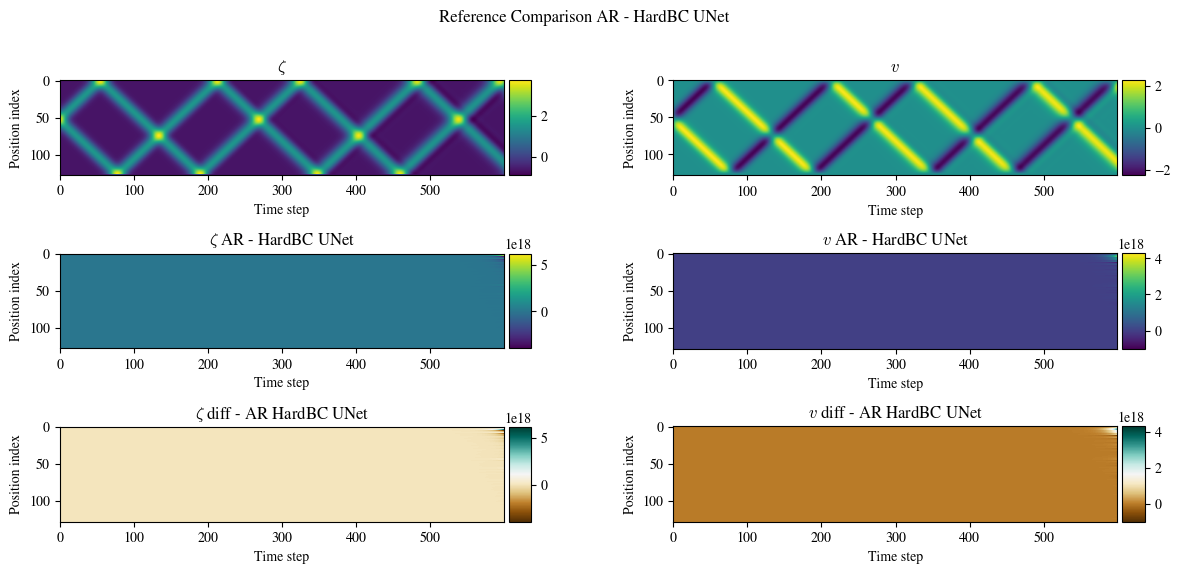

In [39]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_ar_bc_plt, v_ar_bc_plt],
                         title=['$\zeta$ AR - ' + network_name_2, '$v$ AR - ' + network_name_2], showxax=[True, True])
contour_plotter.add_data([zeta_ar_bc_plt - zeta_ref, v_ar_bc_plt - v_ref],
                         title=['$\zeta$ diff - AR ' + network_name_2, '$v$ diff - AR ' + network_name_2],
                         cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison AR - ' + network_name_2)

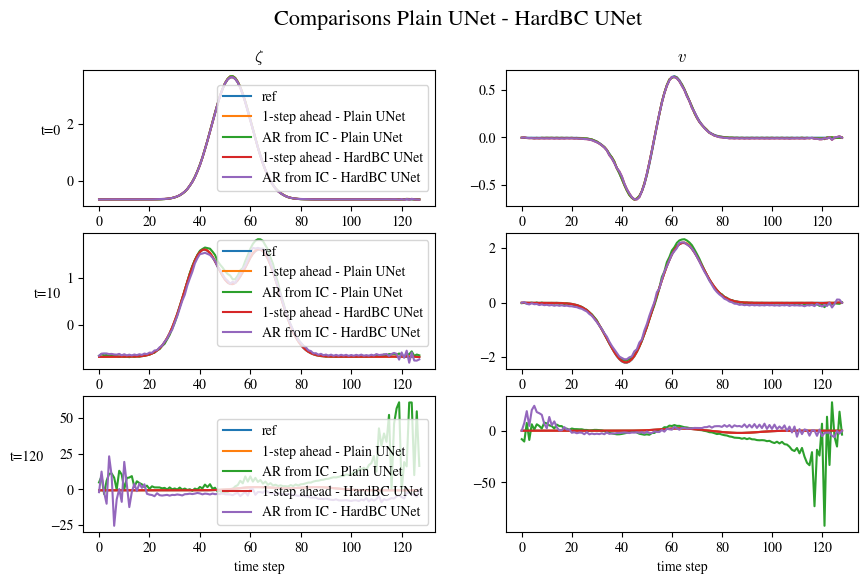

In [40]:
line_plotter = OverlayLinePlot(tsteps=[0, 10, 120])
line_plotter.add_data(zeta_data=zeta_ref, v_data=v_ref, label='ref')
line_plotter.add_data(zeta_data=zeta_est_plt, v_data=v_est_plt, label='1-step ahead - ' + network_name_1)
line_plotter.add_data(zeta_data=zeta_ar_plt, v_data=v_ar_plt, label='AR from IC - ' + network_name_1)
line_plotter.add_data(zeta_data=zeta_est_bc_plt, v_data=v_est_bc_plt, label='1-step ahead - ' + network_name_2)
line_plotter.add_data(zeta_data=zeta_ar_bc_plt, v_data=v_ar_bc_plt, label='AR from IC - ' + network_name_2)
line_plotter.plot_data('Comparisons ' + network_name_1 + ' - ' + network_name_2)

## Task 4: Learn fluxes instead of tendencies
Hyperbolic conservation laws can be written in the form:

$\dfrac{\partial \mathbf{U}}{\partial t} + \dfrac{\partial \mathbf{F}(\mathbf{U})}{\partial \mathbf{x}}=\mathbf{0}$

Instead of outputting the tendencies $\mathbf{U}_t$ for elevation $\zeta$ and velocity $u$, we can also output the fluxes $\mathbf{F}$ calculated on discretized domain corresponding to these variables.
This will guarantee that our neural network will satisfy the conservation laws precisely. In our equation, we know that the $\zeta$ values are conserved but our momentum equation has a source term for bottom drag. Therefore, we can modify our network to output fluxes for $\zeta$ values at velocity locations and tendencies for velocity values.

In [41]:
class UNetFlux(UNet):
    def __init__(self):
        super(UNetFlux, self).__init__()
        self.output_dec_zeta = nn.Conv1d(16, 1, kernel_size=2,
                                         padding=1)  # reduce kernel size to get one more output location

    def forward(self, x_zeta, x_vel):
        F_zeta, delta_vel = super(UNetFlux, self).forward(x_zeta, x_vel)

        # set flux across boundaries to zero
        F_zeta[..., 0] = 0.0
        F_zeta[..., -1] = 0.0

        delta_zeta = torch.diff(F_zeta, dim=-1)
        return delta_zeta, delta_vel

Use this class to run test flux-based learning against the reference solution and previous solvers. Continue to enforce hard BCs as previously using the `HardBCModel` class.

In [42]:
EXP_NAME = 'flux_time_integrator'
log_dir = f'runs/exp_{EXP_NAME}'
writer = SummaryWriter(log_dir=log_dir)
network_name_3 = 'Flux UNet'
net = UNetFlux().to(device)  # instantiate the Unet we defined with random initial parameters
model = HardBCModel(net)

optimizer = optim.Adam(model.parameters(), lr=LR)
trainer = UNetTrainer(model, device, dataloader_train, dataloader_valid, optimizer, criterion, writer, update_function,
                      epochs=EPOCHS)

In [43]:
trainer.train()
torch.save(model.state_dict(), EXP_NAME + '_fluxes.pth')

  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.00378456 Valid Loss: 0.00036124


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.00033847 Valid Loss: 0.00014807


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.00020382 Valid Loss: 0.00009317


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.00016523 Valid Loss: 0.00010224


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.00013309 Valid Loss: 0.00006567


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.00011234 Valid Loss: 0.00008391


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.00010603 Valid Loss: 0.00004611


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.00010068 Valid Loss: 0.00004117


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.00008638 Valid Loss: 0.00007756


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.00008510 Valid Loss: 0.00003600


In [44]:
model.eval();  # use frozen batch norm

In [45]:
# run the network on all data to predict the next time step
zeta_est_f, v_est_f = update_function(model, zeta_in.unsqueeze(1).to(device), v_in.unsqueeze(1).to(device))

In [46]:
# detach from the computation graph and remove unused (channel) dimension
# so we can call plotting functions
zeta_est_f, v_est_f = zeta_est_f.detach().squeeze(1), v_est_f.detach().squeeze(1)
zeta_est_f_plt = zeta_est_f.to('cpu')
v_est_f_plt = v_est_f.to('cpu')

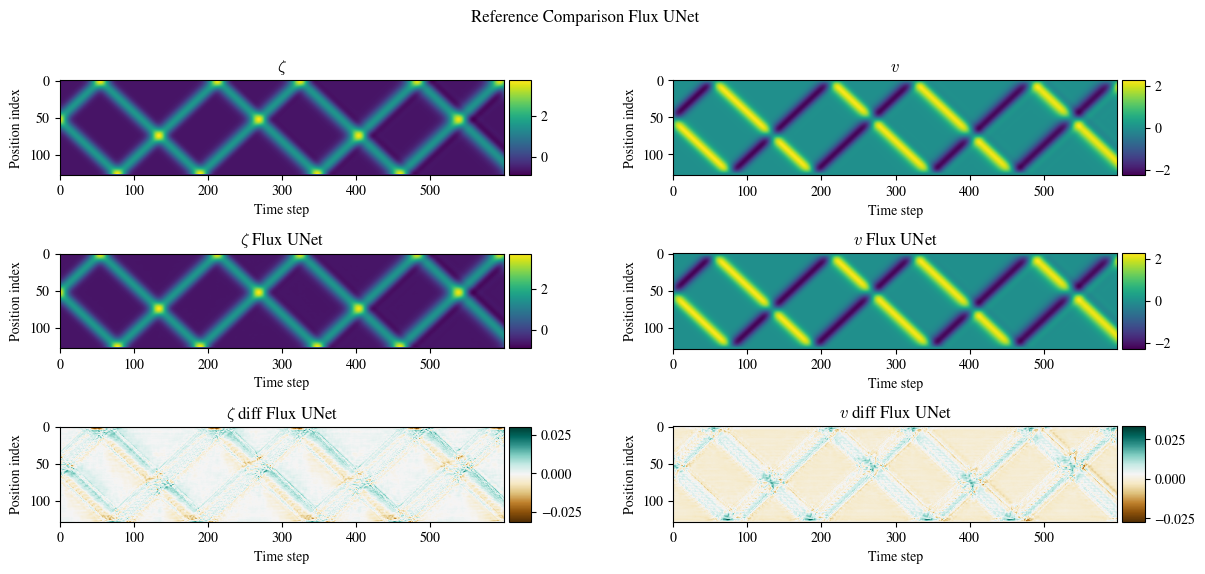

In [47]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_est_f_plt, v_est_f_plt], title=['$\zeta$ ' + network_name_3, '$v$ ' + network_name_3],
                         showxax=[True, True])
contour_plotter.add_data([zeta_est_f_plt - zeta_ref, v_est_f_plt - v_ref],
                         title=['$\zeta$ diff ' + network_name_3, '$v$ diff ' + network_name_3], cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison ' + network_name_3)

In [48]:
zeta_ar_f, v_ar_f = arsolve(zeta_in[0:1, ...].to(device), v_in[0:1, ...].to(device), model)
zeta_ar_f_plt = zeta_ar_f.to('cpu')
v_ar_f_plt = v_ar_f.to('cpu')

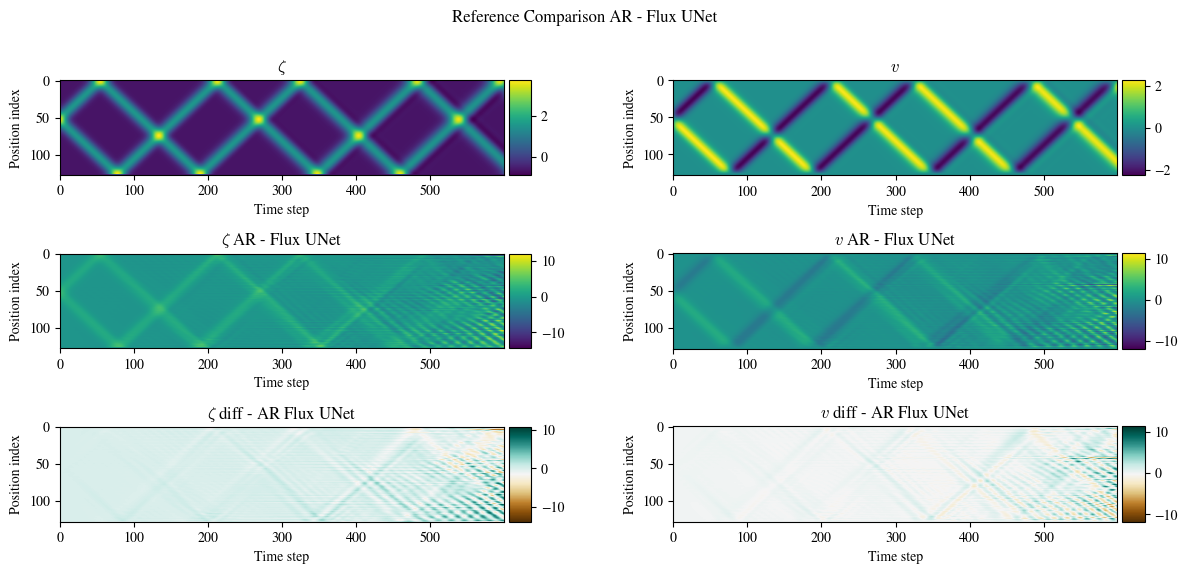

In [49]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_ar_f_plt, v_ar_f_plt],
                         title=['$\zeta$ AR - ' + network_name_3, '$v$ AR - ' + network_name_3], showxax=[True, True])
contour_plotter.add_data([zeta_ar_f_plt - zeta_ref, v_ar_f_plt - v_ref],
                         title=['$\zeta$ diff - AR ' + network_name_3, '$v$ diff - AR ' + network_name_3],
                         cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison AR - ' + network_name_3)

An advantage of flux-base solvers is they obey conservation laws, in this case of mass. Plot the total mass over (that is, the sum of $\zeta$ over space) for each time point of the autoregressive solution of each solver we've tried so far (a log scale on the y-axis may be more informative). Only extend this plot forward in time until the autoregressive solutions start to diverge to infinity, at which point numerical accuracy is compromised.

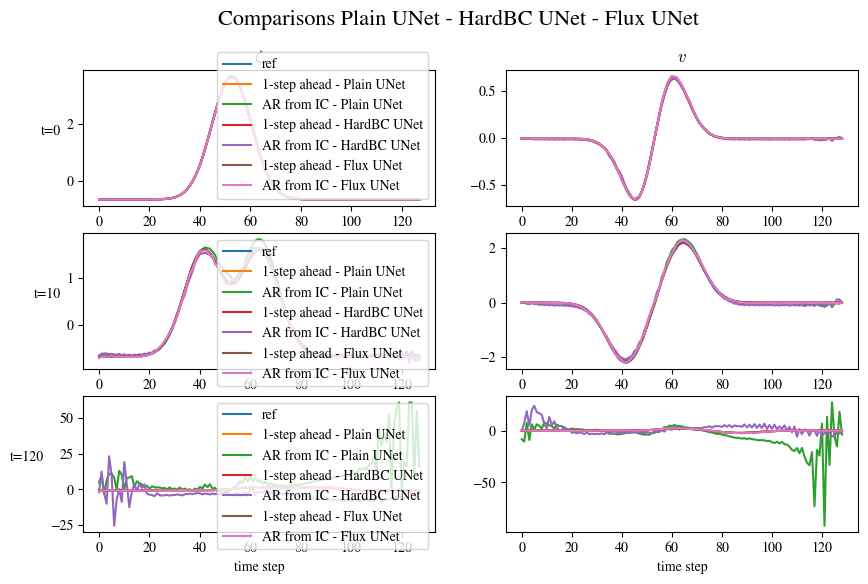

In [50]:
line_plotter = OverlayLinePlot(tsteps=[0, 10, 120])
line_plotter.add_data(zeta_data=zeta_ref, v_data=v_ref, label='ref')
line_plotter.add_data(zeta_data=zeta_est_plt, v_data=v_est_plt, label='1-step ahead - ' + network_name_1)
line_plotter.add_data(zeta_data=zeta_ar_plt, v_data=v_ar_plt, label='AR from IC - ' + network_name_1)
line_plotter.add_data(zeta_data=zeta_est_bc_plt, v_data=v_est_bc_plt, label='1-step ahead - ' + network_name_2)
line_plotter.add_data(zeta_data=zeta_ar_bc_plt, v_data=v_ar_bc_plt, label='AR from IC - ' + network_name_2)
line_plotter.add_data(zeta_data=zeta_est_f_plt, v_data=v_est_f_plt, label='1-step ahead - ' + network_name_3)
line_plotter.add_data(zeta_data=zeta_ar_f_plt, v_data=v_ar_f_plt, label='AR from IC - ' + network_name_3)
line_plotter.plot_data('Comparisons ' + network_name_1 + ' - ' + network_name_2 + ' - ' + network_name_3)

Text(0.5, 0, 'Time step (autoregressive solution from IC)')

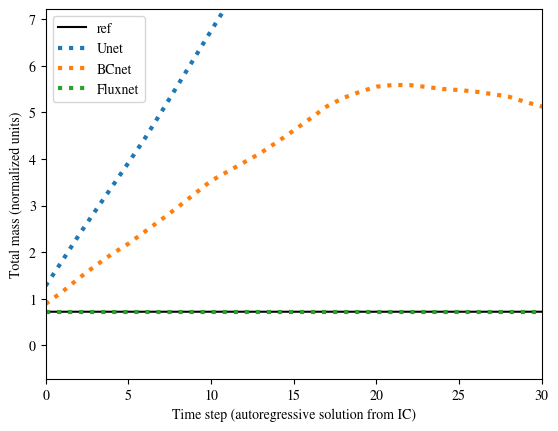

In [51]:
M = zeta_ref.sum(axis=-1).mean()
YL = [- M, 10 * M]
plt.plot(zeta_ref.sum(axis=-1), 'k', label='ref')
plt.plot(zeta_ar_plt.sum(axis=-1), ':', label='Unet', linewidth=3)
plt.plot(zeta_ar_bc_plt.sum(axis=-1), ':', label='BCnet', linewidth=3)
plt.plot(zeta_ar_f_plt.sum(axis=-1), ':', label='Fluxnet', linewidth=3)
plt.ylim(YL)
plt.xlim([0, 30])
plt.legend()
plt.ylabel('Total mass (normalized units)')
plt.xlabel('Time step (autoregressive solution from IC)')

## Task 5: implement a hybrid scheme
We next implement a hybrid approach combining numerical integration and deep learing. Specifically, we will have the network output only $\zeta$, and compute $v$ from $\zeta$ using closed-form equations.

To explain this, we first have to discuss the semiimplicit scheme that has generated our training data so far.

### Semiimplicit time stepping
The update equations for the discretized variables are:
$$v^{n+1} = v^n - \Delta t C_D\frac{1}{h^n}v^n|v^n|- \Delta t g (1-w_{\textbf{imp}}) \frac{\partial \zeta^{n}}{\partial x}-\Delta t g w_{\textbf{imp}} \frac{\partial \zeta^{n+1}}{\partial x}
\\
\zeta^{n+1} = \zeta^n - \Delta t (1-w_{\textbf{imp}}) \frac{\partial h^n v^n}{\partial x}-\Delta t w_{\textbf{imp}} \frac{\partial h^n v^{n+1}}{\partial x}
$$
Recall that $h=h_0+\zeta$ and $h_0$ is the undisturbed water depth. $w_{\textbf{imp}}=0.5$ is a fixed parameter controlling weighting between implicit and explicit time stepping.

Inserting the momentum equation into the mass conservation equation to eliminate $v^{n+1}$, we obtain:

$$\zeta^{n+1} = \zeta^n - \Delta t (1-w_{\textbf{imp}}) \frac{\partial h^n v^n}{\partial x}-\Delta t w_{\textbf{imp}} \frac{\partial h^nv^*}{\partial x} + \Delta t^2 w_{\textbf{imp}}^2g\frac{\partial^2 h^n\zeta^{n+1}}{\partial x^2}$$

where $v^*$ is an explicit prediction for $u$:

$$v^* = v^n - \Delta t c_D\frac{1}{h}v^n|v^n|- \Delta t g (1 - w_{\textbf{imp}}) \frac{\partial \zeta^{n}}{\partial x}$$

The second order spatial derivatives are discretized using the second order finite central difference stencil. Solving for $\zeta^{n+1}$ we obtain the following system of linear equations:

$$\zeta^{n+1}_i = \frac{1}{1+c_E+c_W}\bigg[\zeta^n+\text{div}+c_E\zeta^{n+1}_{i+1}+c_W\zeta^{n+1}_{i-1}\bigg]$$

where $\text{div} = - \Delta t (1-w_{\textbf{imp}})\frac{\partial h^n u^n}{\partial x} -\Delta t w_{\textbf{imp}}\frac{\partial h^nu^*}{\partial x}$, while $c_E$ and $c_W$ are defined as

$c_E=\frac{0.5\Delta t^2w_{\textbf{imp}}^2g (h_i^n+h_{i+1}^n)}{\Delta x^2}$ except at the rightmost $\zeta$ point where $c_E$ is zero.

$c_W =\frac{0.5\Delta t^2w_{\textbf{imp}}^2g (h_i^n+h_{i-1}^n)}{\Delta x^2}$ except at the leftmost $\zeta$ point where $c_W$ is zero.

The linear system can be written in matrix-vector form

$$A \zeta^{n+1} = b$$

where $A$ is a $N \times N$ tridiagonal matrix  with $A_{k,k}=1$, $A_{k, k - 1} = -\frac{c_W}{1 + c_E + c_W}$, $A_{k, k + 1} = - \frac{c_E}{1 + c_E + c_W}$ and all other elements are zero. $b\in\mathbb R^N$ with $b = \frac{\zeta^n +div}{1 + c_E + c_W}$. Having obtained $\zeta^{n+1}$, the new velocity $v^{n+1}$ is calculated as

$v^{n+1} =v^* - \Delta t g w_{\textbf{imp}} \frac{\partial \zeta^{n+1}}{\partial x}$
Note that this formula doesn't apply on the boundaries, where $v$ is prescribed.

## Hybrid time stepping
Given $\zeta^n, v^n$ computing $\zeta^{n+1}$ is computationally expensive since we must solve the linear system. For the small 1-D examples we are considering here one could conceivably invert or factorize $A$, in practice for real-world problems iterative solvers must be used. This makes computation time data-dependent, which hinders parallelization. Thus, skipping this step by using a neural network to obtain $\zeta^{n+1}$ has provide a large speed boost in several studies (though as mentioned above, we won't concern ourselves with trying to quantitatively time anything in this illustrative tutorail).

On the other hand, computing $v^{n+1}$ given $\zeta^n, v^n, \zeta^{n+1}$ is straightforward and inexpensive. There is therefore littel reason for the neural network to learn this inexpensive computation. In our hybrid time stepping scheme, will exploit this computational asymmetry but computing $\zeta^{n+1}$ using the network, but computing $v^{n+1}$ using the same calculations as in the numerical solver. We then proceed to train the network using the same supervised least-squares loss on both $\zeta$ and $v$ as previously.

To compute $v^{n+1}$, we'll need some physical constants and other settings from our numerical scheme:

In [52]:
# New physics informed loss function
# Parameters for the given dataset of SWE.
CD = 1.0e-3
G = 9.81
DT = 300.0
W_IMP = 0.8
H0 = 100.0
DX = 10.0e3  # spactial grid size
N = zeta_ref.shape[-1]  # number of locations in our 1-D zeta grid

In [53]:
# New Architecture
class ZetaUNet(UNetFlux):
    def __init__(self):
        super(ZetaUNet, self).__init__()

    def integrate_vel(self, vel_n, zeta_new, zeta_old):
        # calculate new velocity from old velocity, old height and new height
        h_n = H0 + zeta_old
        h_m = (h_n[..., 1:] + h_n[..., :-1]) / 2.0

        zeta_old_dx = torch.diff(zeta_old, axis=-1) / DX
        zeta_new_dx = torch.diff(zeta_new, axis=-1) / DX
        zeta_old_dx = torch.nn.functional.pad(zeta_old_dx, (1, 1), "constant", 0.0)
        zeta_new_dx = torch.nn.functional.pad(zeta_new_dx, (1, 1), "constant", 0.0)
        h_m = torch.nn.functional.pad(h_m, (1, 1), "constant", 1)

        vel_star = (
                - DT * CD * torch.div(torch.mul(torch.abs(vel_n), vel_n), h_m)
                - DT * G * (1.0 - W_IMP) * zeta_old_dx
        )
        vel_new = vel_star - DT * G * W_IMP * zeta_new_dx
        return vel_new

    def forward(self, x_zeta, x_vel):
        delta_zeta, _ = super(ZetaUNet, self).forward(x_zeta, x_vel)
        zeta_new = x_zeta + delta_zeta

        delta_v = self.integrate_vel(x_vel, zeta_new, x_zeta)

        #enforce boundary conditions
        delta_v[..., 0] = 0.0
        delta_v[..., -1] = 0.0

        return delta_zeta, delta_v

In [54]:
network_name_4 = 'Hybrid UNet'
model = ZetaUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
trainer = UNetTrainer(model, device, dataloader_train, dataloader_valid, optimizer, criterion, writer, update_function,
                      epochs=EPOCHS)

In [ ]:
trainer.train()

  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.00660170 Valid Loss: 0.00509032


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.00531472 Valid Loss: 0.00504303


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.00528128 Valid Loss: 0.00502779


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.00526646 Valid Loss: 0.00502191


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.00525764 Valid Loss: 0.00501945


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.00524980 Valid Loss: 0.00502264


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.00524940 Valid Loss: 0.00501521


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.00524307 Valid Loss: 0.00501334


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.00524324 Valid Loss: 0.00501204


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.00523705 Valid Loss: 0.00501270


Now compare performance to the reference solver and our previous networks.

In [ ]:
model.eval();  # use frozen batch norm

In [ ]:
# run the network on all data to predict the next time step
zeta_est_hyb, v_est_hyb = update_function(model, zeta_in.unsqueeze(1).to(device), v_in.unsqueeze(1).to(device))

In [ ]:
# detach from the computation graph and remove unused (channel) dimension
# so we can call plotting functions
zeta_est_hyb, v_est_hyb = zeta_est_hyb.detach().squeeze(1), v_est_hyb.detach().squeeze(1)
zeta_est_hyb_plt = zeta_est_hyb.to('cpu')
v_est_hyb_plt = v_est_hyb.to('cpu')

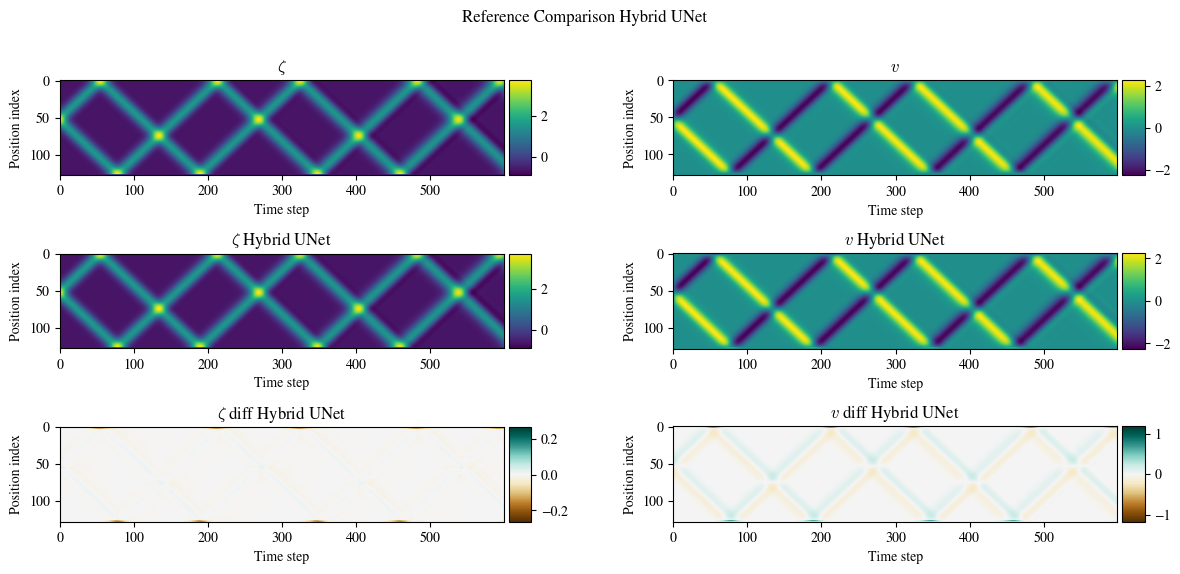

In [ ]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_est_hyb_plt, v_est_hyb_plt],
                         title=['$\zeta$ ' + network_name_4, '$v$ ' + network_name_4], showxax=[True, True])
contour_plotter.add_data([zeta_est_hyb_plt - zeta_ref, v_est_hyb_plt - v_ref],
                         title=['$\zeta$ diff ' + network_name_4, '$v$ diff ' + network_name_4], cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison ' + network_name_4)

In [57]:
# autoregressive
# initialize from IC of reference simulation
zeta_ar_hyb, v_ar_hyb = arsolve(zeta_in[0:1, ...].to(device), v_in[0:1, ...].to(device), model)
zeta_ar_hyb_plt = zeta_ar_hyb.to('cpu')
v_ar_hyb_plt = v_ar_hyb.to('cpu')

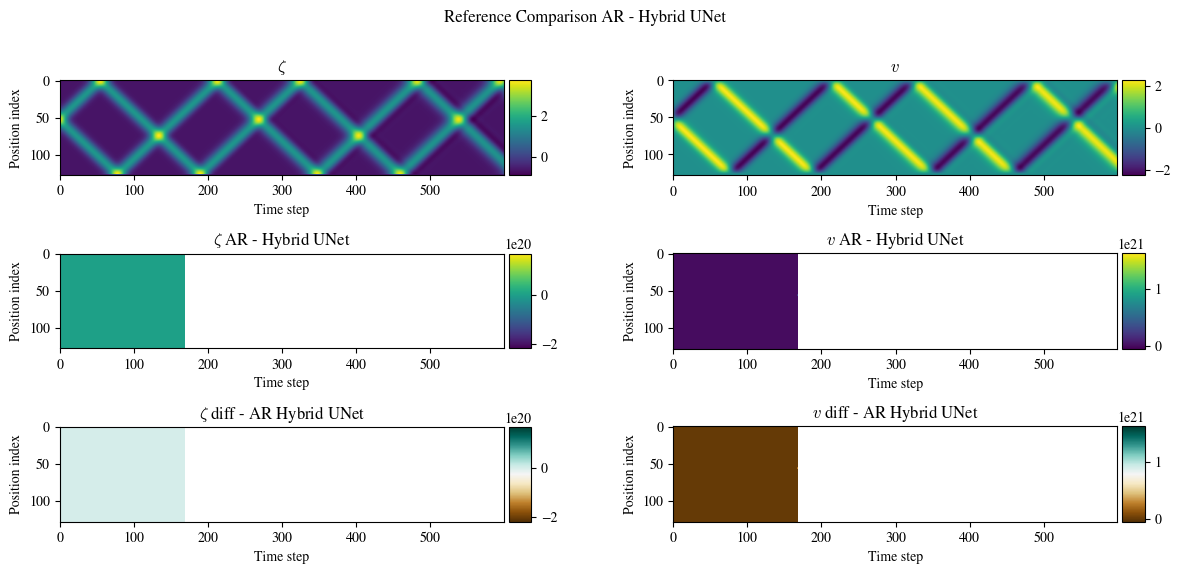

In [59]:
contour_plotter = ContourPlot()
contour_plotter.add_data([zeta_ref, v_ref], title=['$\zeta$', '$v$'], showxax=[True, True])
contour_plotter.add_data([zeta_ar_hyb_plt, v_ar_hyb_plt],
                         title=['$\zeta$ AR - ' + network_name_4, '$v$ AR - ' + network_name_4], showxax=[True, True])
contour_plotter.add_data([zeta_ar_hyb_plt - zeta_ref, v_ar_hyb_plt - v_ref],
                         title=['$\zeta$ diff - AR ' + network_name_4, '$v$ diff - AR ' + network_name_4],
                         cmap=['BrBG', 'BrBG'])
contour_plotter.plot_data('Reference Comparison AR - ' + network_name_4)

Text(0.5, 0, 'Time step (autoregressive solution from IC)')

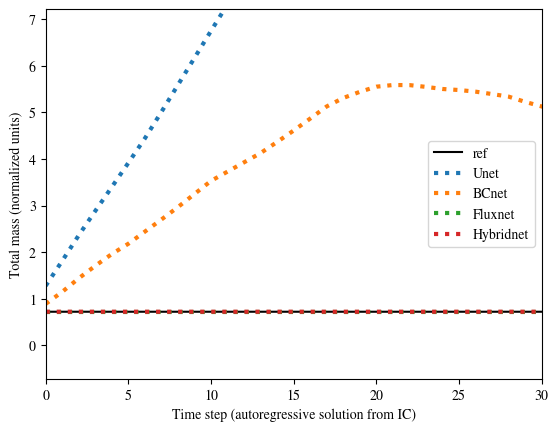

In [61]:
M = zeta_ref.sum(axis=-1).mean()
YL = [- M, 10 * M]
plt.plot(zeta_ref.sum(axis=-1), 'k', label='ref')
plt.plot(zeta_ar_plt.sum(axis=-1), ':', label='Unet', linewidth=3)
plt.plot(zeta_ar_bc_plt.sum(axis=-1), ':', label='BCnet', linewidth=3)
plt.plot(zeta_ar_f_plt.sum(axis=-1), ':', label='Fluxnet', linewidth=3)
plt.plot(zeta_ar_hyb_plt.sum(axis=-1), ':', label='Hybridnet', linewidth=3)
plt.ylim(YL)
plt.xlim([0, 30])
plt.legend()
plt.ylabel('Total mass (normalized units)')
plt.xlabel('Time step (autoregressive solution from IC)')